In [1]:
"""a simple demo of LCA

reference: 
Usher, M., & McClelland, J. L. (2001). 
The time course of perceptual choice: the leaky, competing accumulator model. 
Psychological Review, 108(3), 550–592. 
Retrieved from https://www.ncbi.nlm.nih.gov/pubmed/11488378

adapated from: 
https://github.com/PrincetonUniversity/PsyNeuLink/tree/master/Scripts/Models
"""

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import psyneulink as pnl

sns.set(style='white', context='poster', font_scale=.8, rc={"lines.linewidth": 2})
np.random.seed(0)

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [3]:
# time step
time_step_size = .1

# network params
n_nodes = 3
sd = .2
leak = -1

# Weights
w_input = 1       # w_input (Input to decision layer)
w_cross = .1     # w_cross (Crosstalk input to decision layer)
w_inhib = 1       # w_inhib (Mutual inhibition among decision units)
w_self = 0     # w_self (Self recurrent conn. for each decision unit)
b_dec = 0    # b_dec (Bias input to decision units)

# Weight matrix from Input Layer --> Decision Layer
# Input weights are diagonals, cross weights are off diagonals
identity = np.matrix(np.eye(n_nodes))
mirror_identity = np.ones((n_nodes,n_nodes))
np.fill_diagonal(mirror_identity,0)
input_weights = identity * w_input + mirror_identity * w_cross

# initial states 
initial_value = np.zeros((n_nodes,))
# initial_value = np.random.normal(size=(n_nodes,))

In [4]:
input_layer = pnl.TransferMechanism(
    size=n_nodes,                      # Number of units in input layer
    initial_value=np.zeros(n_nodes,),     # Initial input values
    name='INPUT LAYER'
)

decision_layer = pnl.LCAMechanism(
    size=n_nodes,                            # Number of units in input layer
    initial_value=initial_value,    # Initial input values
    time_step_size=time_step_size,     # Integration step size
    leak=leak,                         # Sets off diagonals to negative values
    self_excitation=w_self,           # Set diagonals to self excitate
    competition=w_inhib,                 # Set off diagonals to inhibit
    function=pnl.Logistic(x_0=b_dec),
    noise=pnl.UniformToNormalDist(standard_deviation=sd).function,
    integrator_mode=True,
    name='DECISION LAYER'
)

# Set initial output values for decision layer to 0
# for output_state in decision_layer.output_states:
#     output_state.value *= 0

decision_process = pnl.Process(
    pathway=[input_layer, input_weights, decision_layer],
    name='DECISION PROCESS'
)

model = pnl.System(
    processes=[decision_process],
    reinitialize_mechanisms_when=pnl.Never()
)

model.show()


---------------------------------------------------------

System-0

	Control enabled: False

	Processes:
		DECISION PROCESS [learning enabled: False]

	Execution sets: 
		Set 0:
			{ INPUT LAYER }
		Set 1:
			{ DECISION LAYER }


In [5]:
# model.show_graph()

In [6]:
input_pattern_set = list(np.eye(n_nodes))
num_time_steps = 80
trials = 2
total_trial_length = trials * num_time_steps

stimuli = np.concatenate([
    np.repeat(np.array([pattern_i]), num_time_steps, axis=0) 
    for pattern_i in input_pattern_set
])

# stimuli = np.concatenate([np.zeros((num_time_steps,n_nodes)) for _ in range(trials)]) 

# assign inputs to input_layer (Origin Mechanism) for each trial
stim_list_dict = {input_layer: stimuli}

# print out the inputs 
print(input_pattern_set)

# run the system
r = model.run(inputs=stim_list_dict, num_trials=total_trial_length)

[array([1., 0., 0.]), array([0., 1., 0.]), array([0., 0., 1.])]


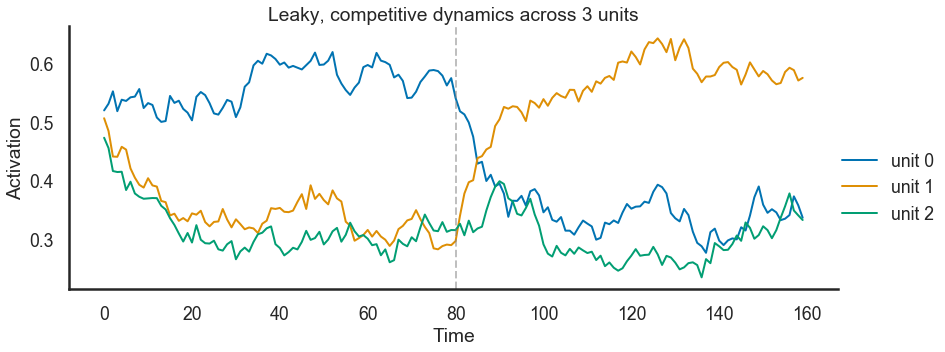

In [13]:
sns.set_palette("colorblind")
# compute event bonds
bonds = np.arange(num_time_steps, total_trial_length, num_time_steps)

# fetch activities (n_time_points x n_neurons)
acts = np.squeeze(model.results)

# plot the dynamics 
f, ax = plt.subplots(1,1, figsize = (12,5))

ax.plot(acts)

ax.set_title(f'Leaky, competitive dynamics across {n_nodes} units')
ax.set_xlabel('Time')
ax.set_ylabel('Activation')
f.legend([f'unit {i}' for i in range(n_nodes)], frameon=False, bbox_to_anchor=(1.1,.6))

for bond in bonds: 
    ax.axvline(bond, color='grey', alpha=.5, linestyle='--')
    
f.tight_layout()
sns.despine()